# 1. Imports 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 2. Load data 

In [3]:
train_df = pd.read_csv('../data/train.csv').drop(columns='id')
#We keep the test_df indexes for submission before droping them 
test_df = pd.read_csv('../data/test.csv')
test_idx = test_df ['id']
test_df = test_df.drop(columns='id')
print(f'Train dataframe shape: {train_df.shape}')
print(f'Test dataframe shape: {test_df.shape}')
TARGET = 'Attrition'
FEATURES = [col for col in train_df.columns if col not in ['row_id',TARGET]]

#People has demonstrated that incorporating original data, improves scores in the public leaderboard
original_df = pd.read_csv('../data/WA_Fn-UseC_-HR-Employee-Attrition.csv').drop(columns='EmployeeNumber')

Train dataframe shape: (1677, 34)
Test dataframe shape: (1119, 33)


In [6]:
train_df.head(5)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


There are 33 unique features to work with and just few training examples (1677) compared to the number of variables. This can lead to overfitting. Hence, adding the original dataset can be a good approach to generalize to unseen data to limit the overfitting. 

It would be interesting to analyze the differences between both datasets as was done in the previous competition by 

# 3. EDA - train data

## 3.1. Overview of the data

In [4]:
#Let's search for NaNs
train_df.isna().sum().sum()

0

In [5]:

#Basic statistics for each variables 
#Background color determined according to the data in each column
#Bar fulfilling the cells in the dataframe according to the value in max and mean columns
train_df.iloc[:,:-1].describe().T.sort_values(by='std', ascending=False)\
    .style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
MonthlyRate,1677.000000,14770.048301,7112.203888,636.000000,8509.000000,15332.000000,20990.000000,26999.000000
MonthlyIncome,1677.000000,6196.049493,4520.050754,1010.000000,2875.000000,4834.000000,7403.000000,19973.000000
DailyRate,1677.000000,892.749553,374.496259,107.000000,589.000000,890.000000,1223.000000,3921.000000
HourlyRate,1677.000000,67.798450,19.435928,30.000000,51.000000,69.000000,84.000000,100.000000
Age,1677.000000,36.036971,8.507112,18.000000,30.000000,35.000000,41.000000,60.000000
DistanceFromHome,1677.000000,8.683959,7.826143,1.000000,2.000000,7.000000,12.000000,29.000000
TotalWorkingYears,1677.000000,10.709600,7.255135,0.000000,6.000000,9.000000,14.000000,41.000000
YearsAtCompany,1677.000000,6.806798,5.883282,0.000000,3.000000,5.000000,9.000000,41.000000
YearsInCurrentRole,1677.000000,4.144305,3.583398,0.000000,2.000000,3.000000,7.000000,18.000000
YearsWithCurrManager,1677.000000,4.186643,3.576189,0.000000,2.000000,3.000000,7.000000,17.000000


## 3.2. Categorical and continuous data

Total number of features: 33
Number of categorical (<25 Unique Values) features: 25
Number of continuos features: 8


([<matplotlib.patches.Wedge at 0x28d6b27f438>,
 [Text(-0.7961074246862808, 0.7590869306998889, 'Categorical (<25 unique values)'),
  Text(0.7961074246862808, -0.759086930699889, 'Continuous')],
 [Text(-0.43424041346524406, 0.41404741674539386, '75.8%'),
  Text(0.43424041346524406, -0.4140474167453939, '24.2%')])

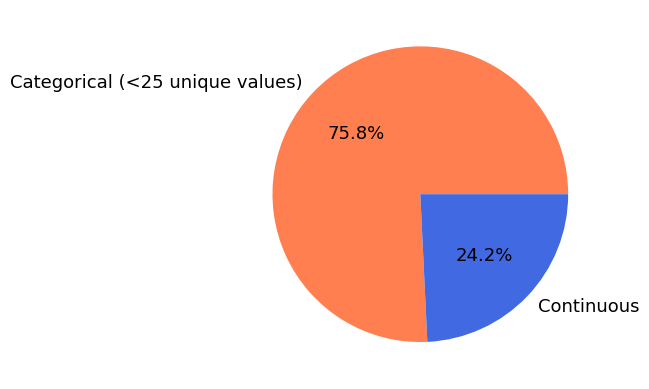

In [85]:
df = pd.concat([train_df[FEATURES], test_df[FEATURES]], axis=0)
categorical_features = [col for col in FEATURES if df[col].nunique()<25]
continuous_features = [col for col in FEATURES if df[col].nunique()>=25]
print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical (<25 Unique Values) features: {len(categorical_features)}')
print(f'\033[93mNumber of continuos features: {len(continuous_features)}')

plt.pie(
    [len(categorical_features), len(continuous_features)],
    labels=['Categorical (<25 unique values)','Continuous'],
    colors=['coral','royalblue'],
    textprops={'fontsize':13},
    autopct='%1.1f%%') #Autopct shows % of the pie in each label

## 3.3. Feature distribution of Continuous features
Show the distribution of the features for each of the 8 continuous features.

- A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. 
- KDE represents the data using a continuous probability density curve in one or more dimensions. 
- Relative to histogram, KDE can produce a plot that is less messy and more interpretable, specially when drawing **multiple** distributions in the same plot. 

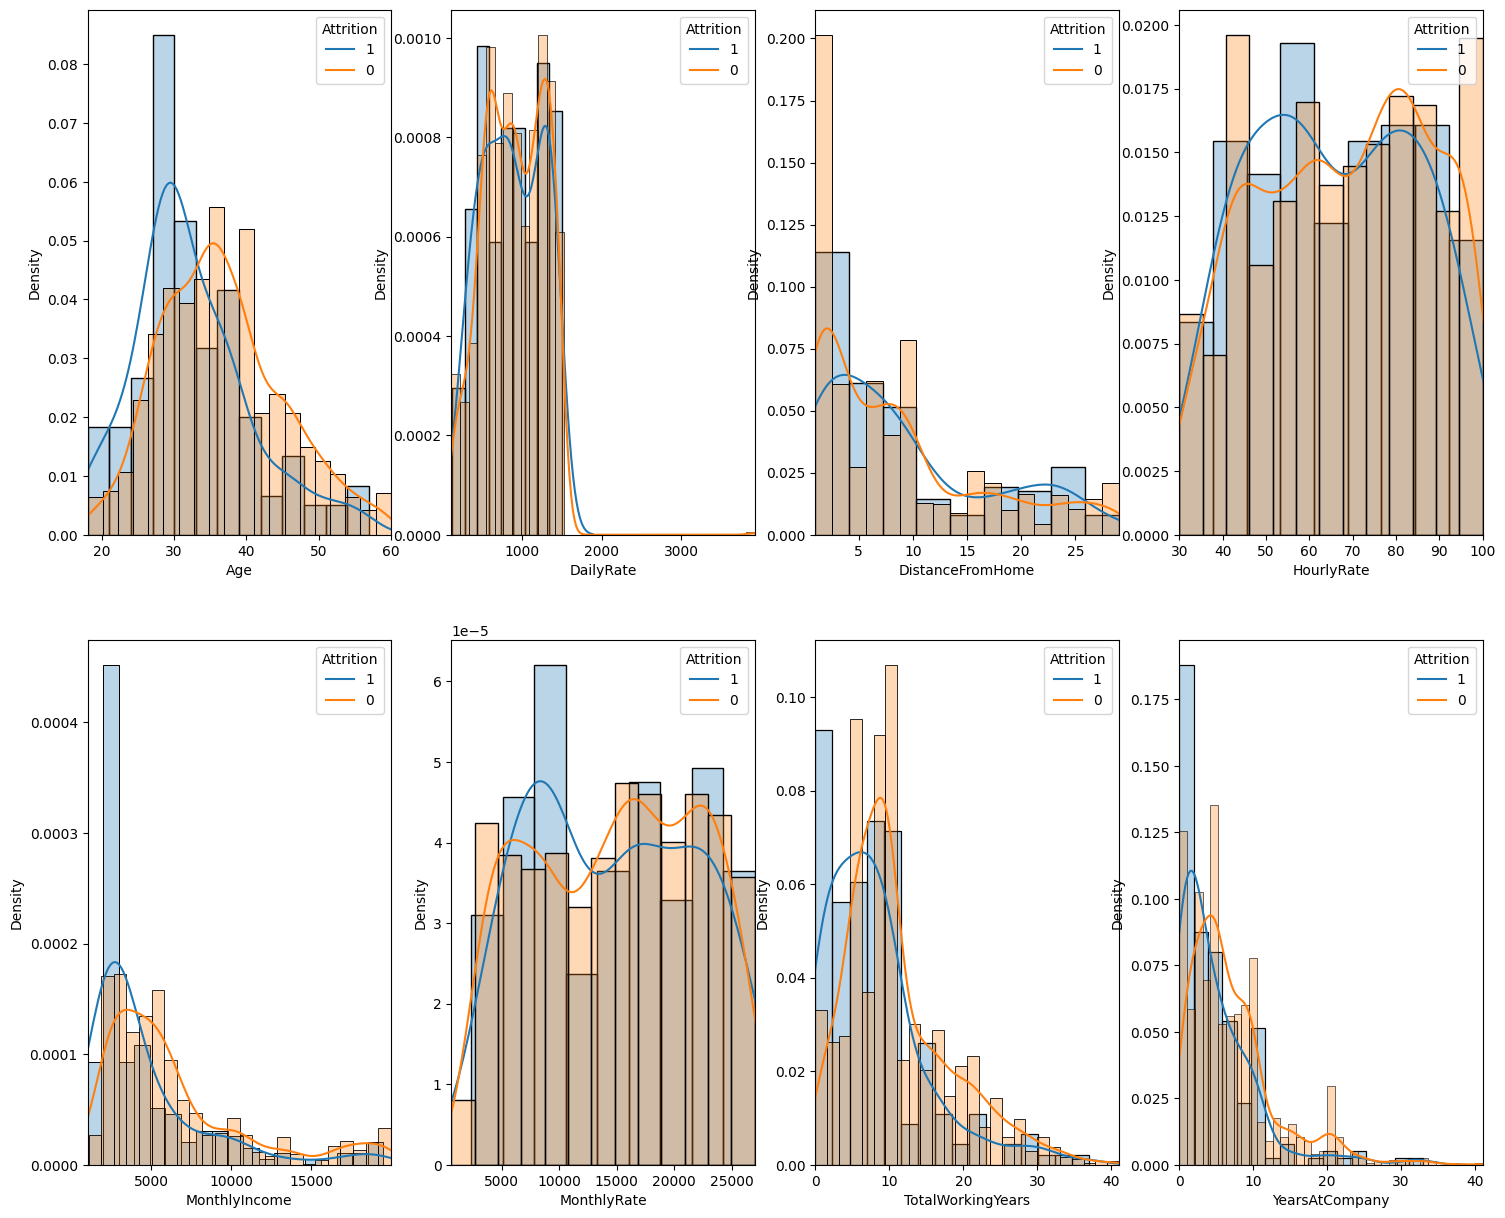

In [80]:
# There are 8 continuous features --> KDE --> (2,4) matrix for subplots
nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(18,15))
for r in range(nrows):
    for c in range(ncols):
        col = np.array(continuous_features).reshape(2,4)[r,c]
        col = continuous_features[r*ncols+c]
        sns.kdeplot(train_df[train_df['Attrition']==1][col], label=1, ax = axes[r,c])
        sns.histplot(train_df[train_df['Attrition']==1][col], alpha = 0.3, stat='density', ax = axes[r,c])
        sns.kdeplot(train_df[train_df['Attrition']==0][col], label = 0, ax = axes[r,c])
        sns.histplot(train_df[train_df['Attrition']==0][col], alpha = 0.3, stat='density', ax = axes[r,c])
        min_f = train_df[col].min()
        max_f = train_df[col].max()
        axes[r,c].legend(title='Attrition')
        axes[r,c].set_xlim([min_f, max_f])

From the continuous plots we can observe the following: 
- Younger people tend to have more attrition 
- People near to the workplace tend to have less attrition
- People who earn less in MonthlyIncome tend to have more attrition
- People who have been less years into the company tend to have more attrition

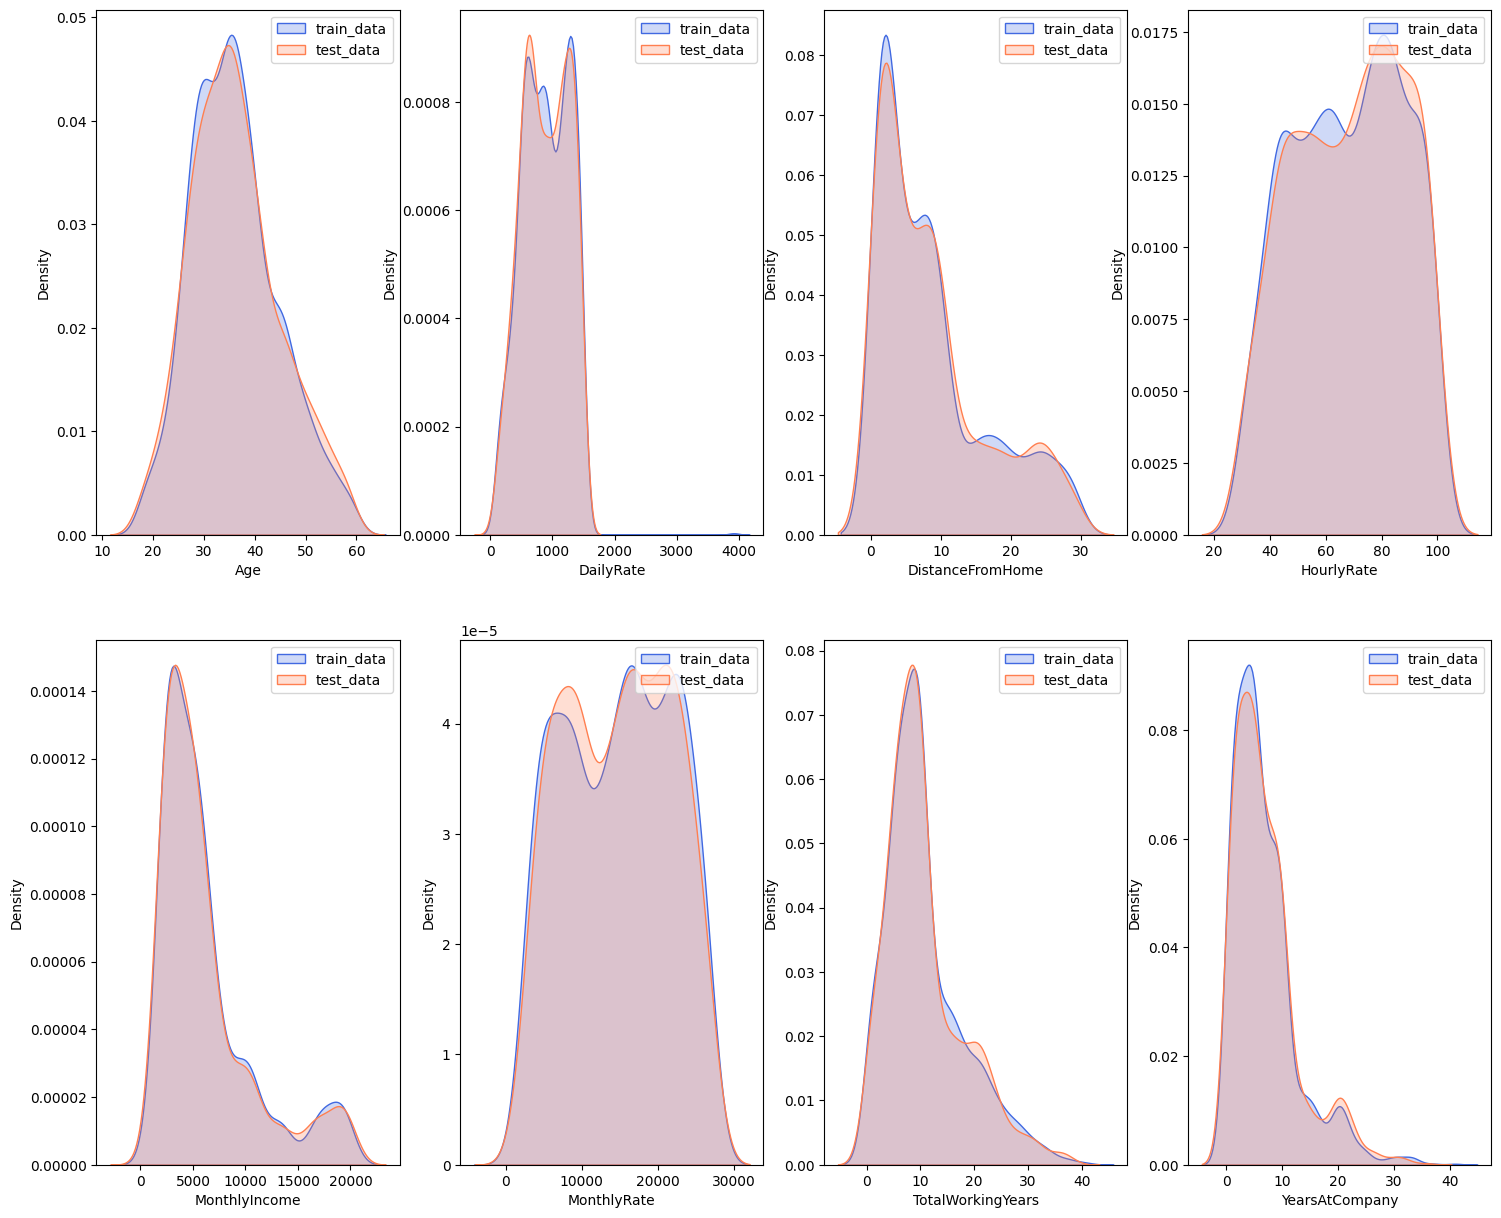

In [61]:
# Comparing trianing and test data
# There are 8 continuous features --> KDE --> (2,4) matrix for subplots
nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(18,15))
for r in range(nrows):
    for c in range(ncols):
        col = np.array(continuous_features).reshape(2,4)[r,c]
        col = continuous_features[r*ncols+c]
        sns.kdeplot(train_df[col],fill=True, color='royalblue',label='train_data',ax = axes[r,c])
        sns.kdeplot(test_df[col],fill=True, color='coral', label='test_data',ax = axes[r,c])
        axes[r,c].legend()



## 3.4. Imputing - Outliers

In [101]:
for col in list(df.columns): 
    print(df[col].value_counts())

34    163
36    158
35    153
31    146
38    144
29    144
40    131
30    109
32    109
27    108
28    105
37     98
39     83
33     81
46     78
41     75
26     74
45     65
42     63
25     61
44     56
43     50
50     48
24     44
48     44
47     38
49     33
23     31
21     30
53     30
22     29
55     29
52     28
51     28
58     25
18     24
19     20
56     17
54     15
59     13
20      8
57      5
60      3
Name: Age, dtype: int64
Travel_Rarely        2089
Travel_Frequently     473
Non-Travel            234
Name: BusinessTravel, dtype: int64
1082    22
1329    20
658     19
688     17
775     16
        ..
535      1
802      1
567      1
792      1
6        1
Name: DailyRate, Length: 734, dtype: int64
Research & Development    1944
Sales                      777
Human Resources             75
Name: Department, dtype: int64
2     443
1     411
10    183
9     176
3     158
8     155
7     154
5     129
6     122
4     109
16     53
18     52
24     52
11     48
15   

- There's one "Education" == 15 that needs to be removed
- There's one "Environment satisfaction" == 0 that needs to be removed
- There's one "JobInvolvement" == 0 that needs to be removed
- There's one "JobLevel" == 7 that needs to be removed
- There's one "StockOptionLevel" == 4 that needs to be removed

These rows with unique values that are outliers/categories with just one rows will be removed from the dataset

In [105]:
train_df = train_df[train_df['Education']!= 15]
train_df = train_df[train_df['EnvironmentSatisfaction']!= 0]
train_df = train_df[train_df['JobInvolvement']!= 0]
train_df = train_df[train_df['JobLevel']!= 7]
train_df = train_df[train_df['StockOptionLevel']!= 4]

test_df = test_df[test_df['Education']!= 15]
test_df = test_df[test_df['EnvironmentSatisfaction']!= 0]
test_df = test_df[test_df['JobInvolvement']!= 0]
test_df = test_df[test_df['JobLevel']!= 7]
test_df = test_df[test_df['StockOptionLevel']!= 4]

# 4.  Encode categorical features

In [106]:
categorical_features

['BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [81]:
train_df[FEATURES]['Age'].value_counts()

36    101
29     96
34     95
31     90
35     89
38     88
40     79
27     67
30     66
28     62
32     60
37     58
39     54
33     50
46     47
26     45
45     41
41     40
44     39
25     36
42     36
50     29
43     29
48     28
24     23
47     22
23     20
49     19
52     18
55     17
21     16
53     15
51     14
22     14
19     13
18     12
59     10
56     10
58      9
54      7
20      6
57      4
60      3
Name: Age, dtype: int64

In [46]:
#We can look at the nunique features and remove from the dataset the ones that are equal to 1. ---> train_df.nunique()
# EmployeeCount, Over18 columns just have one unique value, we can delete them 
train_df = train_df.drop(columns=['EmployeeCount','Over18'])
test_df = test_df.drop(columns=['EmployeeCount','Over18'])
